Copyright 2020 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<p align="center">
  <h1 align="center">TAPIR: Tracking Any Point with per-frame Initialization and temporal Refinement</h1>
  <p align="center">
    <a href="http://www.carldoersch.com/">Carl Doersch</a>
    ·
    <a href="https://yangyi02.github.io/">Yi Yang</a>
    ·
    <a href="https://scholar.google.com/citations?user=Jvi_XPAAAAAJ">Mel Vecerik</a>
    ·
    <a href="https://scholar.google.com/citations?user=cnbENAEAAAAJ">Dilara Gokay</a>
    ·
    <a href="https://www.robots.ox.ac.uk/~ankush/">Ankush Gupta</a>
    ·
    <a href="http://people.csail.mit.edu/yusuf/">Yusuf Aytar</a>
    ·
    <a href="https://scholar.google.co.uk/citations?user=IUZ-7_cAAAAJ">Joao Carreira</a>
    ·
    <a href="https://www.robots.ox.ac.uk/~az/">Andrew Zisserman</a>
  </p>
  <h3 align="center"><a href="https://arxiv.org/abs/2306.08637">Paper</a> | <a href="https://deepmind-tapir.github.io">Project Page</a> | <a href="https://github.com/deepmind/tapnet">GitHub</a> | <a href="https://github.com/deepmind/tapnet/tree/main#running-tapir-locally">Live Demo</a> </h3>
  <div align="center"></div>
</p>

<p align="center">
  <a href="">
    <img src="https://storage.googleapis.com/dm-tapnet/swaying_gif.gif" alt="Logo" width="50%">
  </a>
</p>

In [11]:
# @title Imports {form-width: "25%"}
%matplotlib widget
import functools

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
from tqdm import tqdm
import tree

from tapnet import tapir_model
from tapnet.utils import transforms
from tapnet.utils import viz_utils

# from google.colab import output
# output.enable_custom_widget_manager()

In [3]:
# @title Load Checkpoint {form-width: "25%"}

checkpoint_path = '../checkpoints/causal_tapir_checkpoint.npy'
ckpt_state = np.load(checkpoint_path, allow_pickle=True).item()
params, state = ckpt_state['params'], ckpt_state['state']

In [4]:
# @title Build Model {form-width: "25%"}

# Internally, the tapir model has three stages of processing: computing
# image features (get_feature_grids), extracting features for each query point
# (get_query_features), and estimating trajectories given query features and
# the feature grids where we want to track (estimate_trajectories).  For
# tracking online, we need extract query features on the first frame only, and
# then call estimate_trajectories on one frame at a time.

def build_online_model_init(frames, query_points):
  """Initialize query features for the query points."""
  model = tapir_model.TAPIR(use_causal_conv=True, bilinear_interp_with_depthwise_conv=False)

  feature_grids = model.get_feature_grids(frames, is_training=False)
  query_features = model.get_query_features(
      frames,
      is_training=False,
      query_points=query_points,
      feature_grids=feature_grids,
  )
  return query_features


def build_online_model_predict(frames, query_features, causal_context):
  """Compute point tracks and occlusions given frames and query points."""
  model = tapir_model.TAPIR(use_causal_conv=True, bilinear_interp_with_depthwise_conv=False)
  feature_grids = model.get_feature_grids(frames, is_training=False)
  trajectories = model.estimate_trajectories(
      frames.shape[-3:-1],
      is_training=False,
      feature_grids=feature_grids,
      query_features=query_features,
      query_points_in_video=None,
      query_chunk_size=64,
      causal_context=causal_context,
      get_causal_context=True,
  )
  causal_context = trajectories['causal_context']
  del trajectories['causal_context']
  return {k: v[-1] for k, v in trajectories.items()}, causal_context


online_init = hk.transform_with_state(build_online_model_init)
online_init_apply = jax.jit(online_init.apply)

online_predict = hk.transform_with_state(build_online_model_predict)
online_predict_apply = jax.jit(online_predict.apply)

rng = jax.random.PRNGKey(42)
online_init_apply = functools.partial(
    online_init_apply, params=params, state=state, rng=rng
)
online_predict_apply = functools.partial(
    online_predict_apply, params=params, state=state, rng=rng
)

In [5]:
# @title Utility Functions {form-width: "25%"}

def preprocess_frames(frames):
  """Preprocess frames to model inputs.

  Args:
    frames: [num_frames, height, width, 3], [0, 255], np.uint8

  Returns:
    frames: [num_frames, height, width, 3], [-1, 1], np.float32
  """
  frames = frames.astype(np.float32)
  frames = frames / 255 * 2 - 1
  return frames


def postprocess_occlusions(occlusions, expected_dist):
  """Postprocess occlusions to boolean visible flag.

  Args:
    occlusions: [num_points, num_frames], [-inf, inf], np.float32

  Returns:
    visibles: [num_points, num_frames], bool
  """
  pred_occ = jax.nn.sigmoid(occlusions)
  pred_occ = 1 - (1 - pred_occ) * (1 - jax.nn.sigmoid(expected_dist))
  visibles = pred_occ < 0.5  # threshold
  return visibles


def sample_random_points(frame_max_idx, height, width, num_points):
  """Sample random points with (time, height, width) order."""
  y = np.random.randint(0, height, (num_points, 1))
  x = np.random.randint(0, width, (num_points, 1))
  t = np.random.randint(0, frame_max_idx + 1, (num_points, 1))
  points = np.concatenate((t, y, x), axis=-1).astype(np.int32)  # [num_points, 3]
  return points


def construct_initial_causal_state(num_points, num_resolutions):
  value_shapes = {
      "tapir/~/pips_mlp_mixer/block_1_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_1_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_2_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_2_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_3_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_3_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_4_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_4_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_5_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_5_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_6_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_6_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_7_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_7_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_8_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_8_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_9_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_9_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_10_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_10_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_11_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_11_causal_2": (1, num_points, 2, 2048),
      "tapir/~/pips_mlp_mixer/block_causal_1": (1, num_points, 2, 512),
      "tapir/~/pips_mlp_mixer/block_causal_2": (1, num_points, 2, 2048),
  }
  fake_ret = {
      k: jnp.zeros(v, dtype=jnp.float32) for k, v in value_shapes.items()
  }
  return [fake_ret] * num_resolutions * 4

In [6]:
# @title Load an Exemplar Video {form-width: "25%"}

%mkdir data/examplar_videos

!wget -P data/examplar_videos https://storage.googleapis.com/dm-tapnet/horsejump-high.mp4

video = media.read_video('data/examplar_videos/horsejump-high.mp4')
height, width = video.shape[1:3]
media.show_video(video, fps=10)

mkdir: cannot create directory ‘data/examplar_videos’: No such file or directory
--2023-12-05 00:28:27--  https://storage.googleapis.com/dm-tapnet/horsejump-high.mp4
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.16.155, 172.217.16.219, 216.58.206.59, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.16.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 467706 (457K) [video/mp4]
Saving to: ‘data/examplar_videos/horsejump-high.mp4’

horsejump-high.mp4  100%[===================>] 456,74K   935KB/s    in 0,5s    

2023-12-05 00:28:28 (935 KB/s) - ‘data/examplar_videos/horsejump-high.mp4’ saved [467706/467706]



In [7]:
# @title Progressively Predict Sparse Point Tracks {form-width: "25%"}

resize_height = 256  # @param {type: "integer"}
resize_width = 256  # @param {type: "integer"}
num_points = 20  # @param {type: "integer"}

frames = media.resize_video(video, (resize_height, resize_width))
query_points = sample_random_points(0, frames.shape[1], frames.shape[2], num_points)

query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)

# Predict point tracks frame by frame
predictions = []
for i in range(frames.shape[0]):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1)

visibles = postprocess_occlusions(occlusions, expected_dist)

# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles)
media.show_video(video_viz, fps=10)

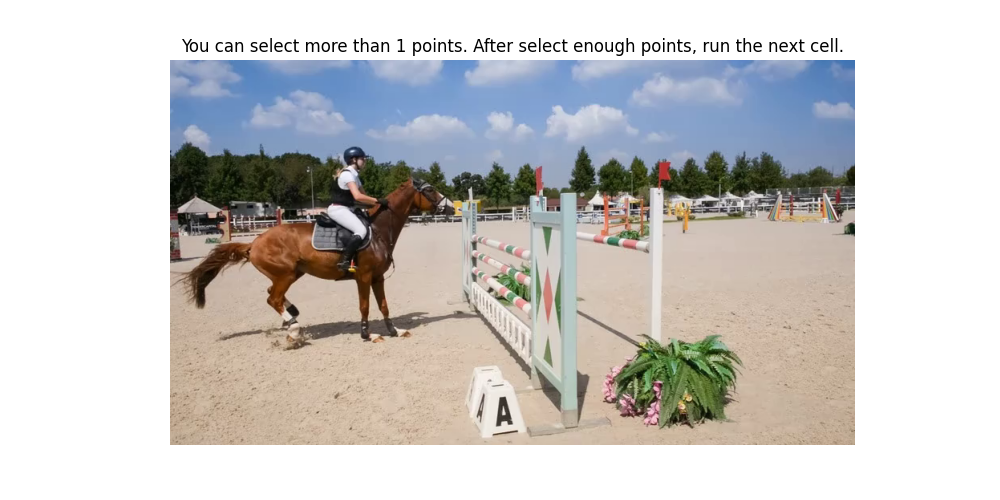

In [8]:
# @title Select Any Points at First Frame {form-width: "25%"}

# Generate a colormap with 20 points, no need to change unless select more than 20 points
colormap = viz_utils.get_colors(20)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(video[0])
ax.axis('off')
ax.set_title('You can select more than 1 points. After select enough points, run the next cell.')

select_points = []

 # Event handler for mouse clicks
def on_click(event):
  if event.button == 1 and event.inaxes == ax:  # Left mouse button clicked
    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))

    select_points.append(np.array([x, y]))

    color = colormap[len(select_points) - 1]
    color = tuple(np.array(color) / 255.0)
    ax.plot(x, y, 'o', color=color, markersize=5)
    plt.draw()

fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

In [9]:
# @title Predict Point Tracks for the Selected Points {form-width: "25%"}

resize_height = 256  # @param {type: "integer"}
resize_width = 256  # @param {type: "integer"}

def convert_select_points_to_query_points(frame, points):
  """Convert select points to query points.

  Args:
    points: [num_points, 2], [t, y, x]
  Returns:
    query_points: [num_points, 3], [t, y, x]
  """
  points = np.stack(points)
  query_points = np.zeros(shape=(points.shape[0], 3), dtype=np.float32)
  query_points[:, 0] = frame
  query_points[:, 1] = points[:, 1]
  query_points[:, 2] = points[:, 0]
  return query_points

frames = media.resize_video(video, (resize_height, resize_width))
query_points = convert_select_points_to_query_points(0, select_points)
query_points = transforms.convert_grid_coordinates(
    query_points, (1, height, width), (1, resize_height, resize_width), coordinate_format='tyx')

query_features, _ = online_init_apply(frames=preprocess_frames(frames[None, None, 0]), query_points=query_points[None])
causal_state = construct_initial_causal_state(query_points.shape[0], len(query_features.resolutions) - 1)

# Predict point tracks frame by frame
predictions = []
for i in tqdm(range(frames.shape[0])):
  (prediction, causal_state), _ = online_predict_apply(
      frames=preprocess_frames(frames[None, None, i]),
      query_features=query_features,
      causal_context=causal_state,
  )
  predictions.append(prediction)

tracks = np.concatenate([x['tracks'][0] for x in predictions], axis=1)
occlusions = np.concatenate([x['occlusion'][0] for x in predictions], axis=1)
expected_dist = np.concatenate([x['expected_dist'][0] for x in predictions], axis=1)

visibles = postprocess_occlusions(occlusions, expected_dist)

# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles, colormap)
media.show_video(video_viz, fps=10)

100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


That's it!